In [3]:
# hiding slideshow setup etc
hide_toggle(for_next=True)

In [2]:
from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 's'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' _'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current,
        toggle_text=toggle_text
    )

    return HTML(html)

tata_steel = "https://i.guim.co.uk/img/media/447f7e234d9f432480a3c5bb0ec596c12ce869c5/0_340_5100_3060/master/5100.jpg?width=1900&dpr=1&s=none"
ebsd_scan = "https://i.imgur.com/YOQ9mzO.png"
apd_ebsd = "https://i.imgur.com/HobMKDG.png"
pyapd_logo = "https://raw.githubusercontent.com/mbuze/PyAPD/main/logo/logo.png"


#!/usr/bin/env python3
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path
path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
cm.update(
    "rise",
    {
        "theme": "moon",
        "transition": "none",
        "start_slideshow_at": "selected",
        "enable_chalkboard": True,
     }
)

{'theme': 'moon',
 'transition': 'none',
 'start_slideshow_at': 'selected',
 'enable_chalkboard': True}

# Generative Adversarial Networks with applications in microstructure modelling: Part 1

### 2024 CMIT Summer Research Internship Programme, University of Liverpool, 16 July 2024


#### Maciej Buze, Heriot-Watt University



## Course Information

- My contact information:
   - Email: [m.buze@hw.ac.uk](mailto:m.buze@hw.ac.uk) -> questions / comments / reflections very welcome!
   - Website: https://mbuze.github.io
   - Potential PhD projects starting in October 2025 or October 2026 -> get in touch!
<br><br>
- Github repo with course materials:<br>
https://github.com/mbuze/GAN_microstructure_modelling
<br><br>
- Slides/Notes/Exercises via Jupyter notebooks
<br><br>
- Other relevant Python library PyAPD: https://github.com/mbuze/PyAPD

## Course aims and structure

### Aims

A gentle hands-on introducton to
1. Microstructure modelling as a mathematical imaging problem
1. Generative Adversarial Networks - a well-known generative AI framework

### Structure
- Two ~2-hour lectures: (i) Tuesday 16 July 9:30-11:30 BST, (ii) Friday 19 July 9:30-11:30 BST
- Blend of theory and live coding
- Modest homework in the form of a Jupyter notebook
- Reproducible code to play around with

## Motivation

In [4]:
hide_toggle(for_next=True)

In [ ]:
Image(url= tata_steel, width=1350)

In [5]:
hide_toggle(for_next=True)

In [6]:
Image(url= ebsd_scan, width=1050)

In [ ]:
hide_toggle(for_next=True)

In [ ]:
display(HTML(f"""<table><tr><td><img src={ebsd_scan} width="600"></td><td><img src={apd_ebsd} width="600"></td></tr></table>"""))

,


In [ ]:
hide_toggle(for_next=True)

In [ ]:
Image(url= pyapd_logo, width=1100)

## Training data generation

In [7]:
pip install PyAPD

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.8/238.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-

In [8]:
import PyAPD
import matplotlib.pyplot as plt # for plotting
import torch # go-to machine learning Python library
import numpy as np # NumPy is the fundamental package for scientific computing with Python.

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [9]:
apd1 = PyAPD.apd_system(
    N=15, # number of grains
    ani_thres=0.5, # anisotropy parameter
    pixel_size_prefactor=5, # create this times as many pixels (good for nice plots)
    )
apd1.assemble_pixels() # defining the pixels

In [10]:
%%capture
apd1.Lloyds_algorithm( # # algorithm for generating nice microstructure
    K=10, # number of iterations
)

## Training data generation

(<Figure size 756x756 with 1 Axes>, <Axes: >)

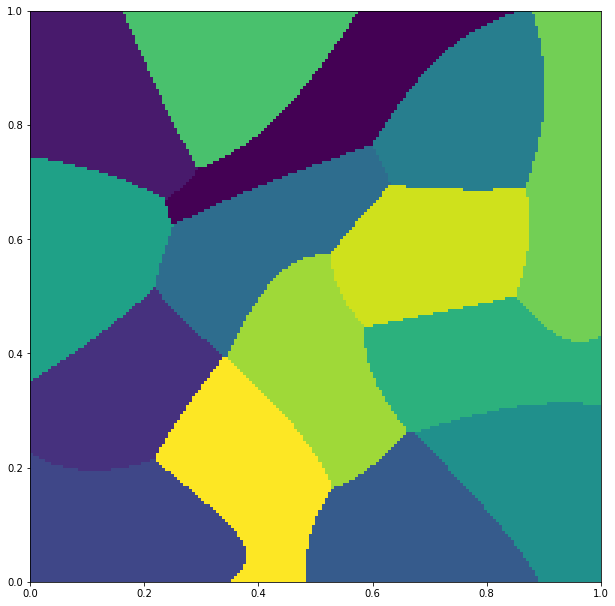

In [ ]:
apd1.plot_apd()

## Training data generation

In [11]:
img = apd1.assemble_apd().reshape(apd1.pixel_params).transpose(0,1).cpu()
img_s = (img + 1)/img.max() #shift values to [0,1]

In [12]:
img_s[0,0]

tensor(0.2143)

Full data generation algorithm (see stand-alone [notebook in the Github repo](https://github.com/mbuze/GAN_microstructure_modelling/blob/main/notebooks/generating_pyapd_data.ipynb) ):

In [ ]:
# for i in range(0,14162):
#     apd1 = PyAPD.apd_system(N=15, ani_thres=0.5, seed = i)
#     apd1.check_optimality()
#     apd1.Lloyds_algorithm(K=10, verbosity_level = 0 )
#     img = apd1.assemble_apd().reshape(apd1.pixel_params).transpose(0,1).cpu()
#     img_s = (img + 1)/(img+1).max()  #shift values to [0,1]
#     plt.imsave(f'data/apd_data/train/mono_disperse_small/pic{i}.png', img_s,cmap=plt.cm.gray) # saving an image

## Inspecting the data

In [13]:
import os
import requests
import zipfile
from pathlib import Path

In [14]:
# Setup path to data folder
data_path = Path("data/") # path to data folder
image_path = data_path / "apd_data" # path to the specific subfolder
# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    # Download PyAPD data
    with open(data_path / "apd_data.zip", "wb") as f:
        request = requests.get("https://github.com/mbuze/GAN_microstructures_Summer_School/raw/main/data/apd_data.zip")
        print("Downloading PyAPD data...")
        f.write(request.content)
    # Unzip the data
    with zipfile.ZipFile(data_path / "apd_data.zip", "r") as zip_ref:
        print("Unzipping PyAPD data...")
        zip_ref.extractall(image_path)

Did not find data/apd_data directory, creating one...
Unzipping PyAPD data...


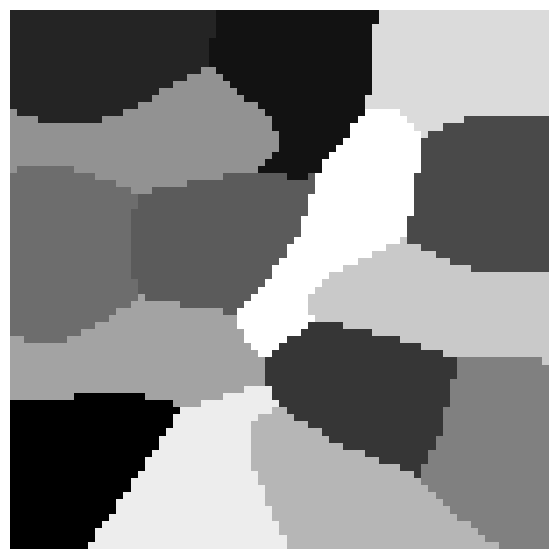

In [15]:
import random # random number generator
from PIL import Image # opening images from files
# Set seed
random.seed(41) # <- try changing this and see what happens
# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.png"))
#2. Get random image path
random_image_path = random.choice(image_path_list)
# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# 4. Open image
img = Image.open(random_image_path)
# Turn the image into an array
img_as_array = np.asarray(img)
# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)#,cmap=plt.cm.gray)
plt.axis(False);

## Summary

- Polycrystalline metals and alloys comprise of grains with different shape, size, and crystallographic orientation.
- This leads to an interesting mathematical imaging problem.
- An ability to create high-quality artificial computer samples is highly desirable.
- AI frameworks can help, but they rely on data.
- We have created artificial data and next time we meet we will use it to train a machine learning model.
- Final few slides contain homework exercises.

## Homework

(1) How many data points (images) does our dataset contain? You can either just type in the number or run a command that will output the number. (Hint: you can get it easily using commands from the data inspection)

In [ ]:
# answer here
len(image_path_list)

(2) Display the 500th image from the dataset.

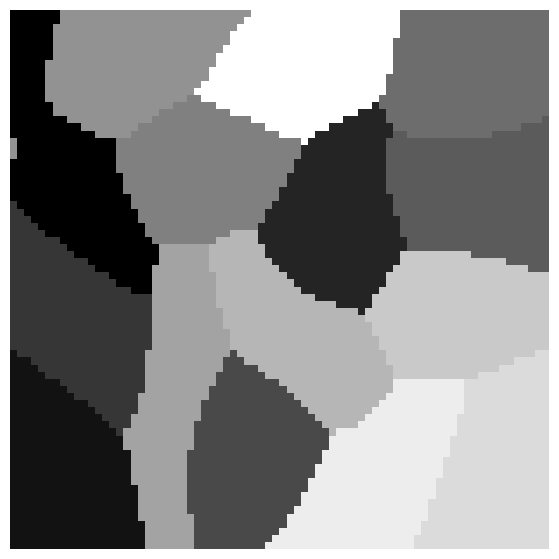

In [19]:
# code goes here
img = Image.open(image_path_list[499])

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))

plt.imshow(img_as_array)#,cmap=plt.cm.gray）

plt.axis(False);


(3) In the presentation the images were coloured, but in the dataset the images are grayscale. Discuss why (there is a specific line of code responsible for it). Do you think that it matters? Is it beneficial or detrimental?

***plt.imshow(img_as_array)#,cmap=plt.cm.gray)***, this is the code that resposible for it.

**I don't think it matters. As the colors are composed by RGB (i.e. red, blue, green), it has three layers repectively. However, if we consider the gray one, which is composed by only white and black, each area is presented by the different degree of composition. So we just need computer learn the weight of each small area, and computer cannot recognize the color, it only can regonize number.**

**And I think it is benificial, as I think it will release the pressure for GPU, as it only needs to learn one layer. On the other hand, as we reduce the number of layer from 3 to 1, it will lose some features about colors.**


(4) What are the common features of all the images we produced? (This is ultimately what we want the machine learning algorithm to learn for itself!). Try to think of at least four different features, but feel free to list as many as you want.

**Common features:**

1.   The edge of each area with uniform color is unclear.
2.   Each area with uniform colors partially cover other areas.

**Different features**
1.   The color is distributed at random.
2.   The pattern is distributed at random.





